In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_698.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_386.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_858.wav
/kaggle/input/shl-intern-hiring-ass

In [2]:
# Load CSVs
train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv')
sample_submission = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv')

# Display some rows
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


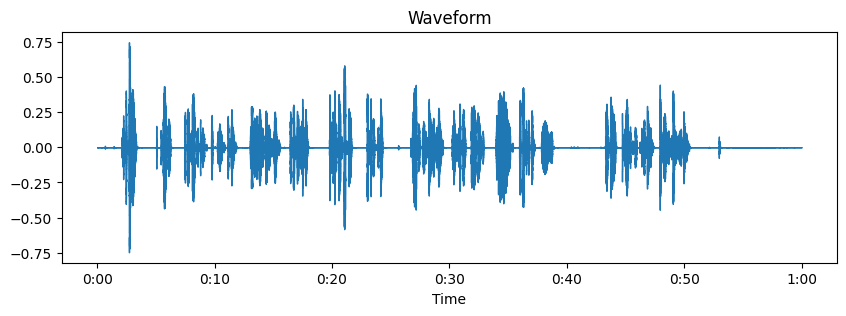

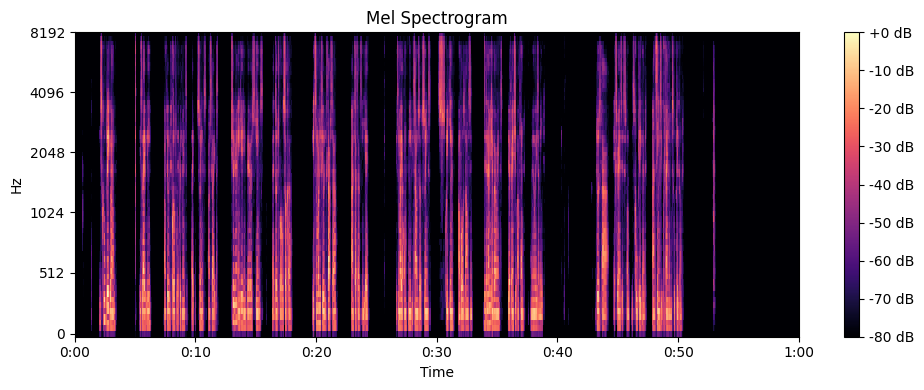

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load and visualize one example
sample_audio = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/audio_1008.wav'  
y, sr = librosa.load(sample_audio, sr=16000)

# Display waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()


In [4]:
def extract_mfcc_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.concatenate((mfcc, delta, delta2), axis=0)
    return combined.mean(axis=1)


In [5]:
print(train_df.columns)


Index(['filename', 'label'], dtype='object')


In [6]:
from tqdm import tqdm

AUDIO_DIR = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train'

X_train = []
y_train = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(AUDIO_DIR, row['filename'])
    features = extract_mfcc_features(file_path)
    X_train.append(features)
    y_train.append(row['label'])

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 444/444 [00:47<00:00,  9.35it/s]


In [7]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# Predict on training set
train_preds = model.predict(X_train)
pearson = pearsonr(train_preds, y_train)[0]

print(f"Training Pearson Correlation: {pearson:.4f}")


Training Pearson Correlation: 0.9785


In [8]:
X_test = []

TEST_AUDIO_DIR = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test'

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(TEST_AUDIO_DIR, row['filename'])
    features = extract_mfcc_features(file_path)
    X_test.append(features)

X_test = np.array(X_test)


100%|██████████| 195/195 [00:20<00:00,  9.47it/s]


In [9]:
# Generate predictions for the test set
test_preds = model.predict(X_test)

# Round predictions to one decimal place
test_preds_rounded = np.round(test_preds, 1)

# Prepare submission dataframe
submission = test_df.copy()
submission['label'] = test_preds_rounded

# Save submission file
submission.to_csv('submission.csv', index=False)
submission


,filename,label
0,audio_706.wav,3.1
1,audio_800.wav,2.9
2,audio_68.wav,3.7
3,audio_1267.wav,3.2
4,audio_683.wav,3.6
...,...,...
190,audio_135.wav,3.2
191,audio_512.wav,4.2
192,audio_529.wav,4.3
193,audio_762.wav,3.6
